1. Importação de bibliotecas e organização geral

Neste bloco são importadas as bibliotecas utilizadas.

In [ ]:
import math
import matplotlib.pyplot as plt
from dataclasses import dataclass
import numpy as np
import pandas as pd

2. Definição dos parâmetros globais do modelo

Aqui são definidos, em Params, os parâmetros do sistema. Eles representam:

- capacidades de injeção e razões entre poços;

- eficiências de reforma, captura, transporte e armazenamento;

- fatores de emissão e consumos específicos de energia;

- emissões de construção das principais infraestruturas.

Esses parâmetros correspondem às constantes usadas nas equações da seção de metodologia.

In [ ]:
# ============================================================
# Parâmetros e entradas
# ============================================================

@dataclass
class Params:
    # Capacidade anual de injeção de CO₂ por poço (tCO₂/ano)
    capacidade_injecao_poco: float = 563_867
    # Razão entre poços de monitoramento e poços injetores
    razao_pocos_monitoramento: float = 1
    # Fator de disponibilidade da planta de H₂ (fração do ano em operação)
    fator_disponibilidade_planta: float = 0.85
    # Eficiência global da reforma a vapor de etanol (η_reforma)
    eficiencia_reforma_etanol: float = 0.71
    # Eficiência de captura de CO₂ (η_cap)
    eficiencia_captura_co2: float = 0.9
    # Eficiência de transporte de CO₂ (η_transp)
    eficiencia_transporte_co2: float = 1
    # Eficiência de armazenamento de CO₂ (η_armz)
    eficiencia_armazenamento_co2: float = 1
    # Fator de emissão da produção de etanol (tCO₂eq/t etanol)
    fe_producao_etanol: float = 0.433
    # Vida útil da planta de H₂ (anos)
    tempo_vida_planta_h2: int = 15
    # Vida útil do gasoduto (anos)
    tempo_vida_gasoduto: int = 30
    # Vida útil dos poços injetores (anos)
    tempo_vida_pocos_injetores: int = 15
    # Consumo específico de energia da produção de H₂ (kWh/kg H₂)
    ce_producao_h2: float = 5
    # Consumo específico de energia do transporte de CO₂ (kWh/km·kg CO₂)
    ce_transporte_co2: float = 0.00025
    # Consumo específico de energia da injeção de CO₂ (kWh/kg CO₂)
    ce_injecao_co2: float = 0.01084
    # Emissão de construção do gasoduto (tCO₂eq/km)
    emissao_construcao_gasoduto: float = 713.44776177
    # Emissão de construção dos poços (tCO₂eq/m)
    emissao_construcao_pocos_injetores: float = 0.854172
    # Emissão de construção da planta de reforma (tCO₂eq/kg H₂ ao longo da vida útil, depois ajustada)
    emissao_construcao_reforma: float = 0.000047552

3. Definição da estrutura de entrada para cenários

A classe Inputs representa os parâmetros que variam entre cenários:

- tamanho do gasoduto;

- profundidade dos poços;

- fator de emissão da eletricidade;

- emissões de CO₂ da fermentação por unidade de etanol;

- intervalo de produção horária de H₂ para simulação das curvas.

In [ ]:
@dataclass
class Inputs:
    # Comprimento do gasoduto de CO₂ (km)
    tamanho_gasoduto: float
    # Profundidade média de injeção (m)
    profundidade_injecao: float
    # Fator de emissão da eletricidade (kgCO₂eq/kWh)
    fe_eletricidade: float
    # Emissão de CO₂ da fermentação (tCO₂/t etanol)
    emissao_fermentacao_co2: float
    # Faixa de produção horária de H₂ (kg/h) para traçar as curvas
    producao_horaria_h2_range: np.ndarray = np.arange(5, 550, 5)

4. Função calcular_fluxos: balanço de massa

Esta função implementa o balanço de massa da reforma de etanol:

- converte produção horária em produção anual de H₂ ajustada pelo fator de disponibilidade;

- usa a estequiometria da reação global para calcular o consumo de etanol e a geração de CO₂ da reforma.

Corresponde às equações de produção anual de H₂, consumo de etanol e geração de CO₂ apresentadas na metodologia.

In [ ]:
# ============================================================
# Funções de cálculo
# ============================================================

def calcular_fluxos(producao_h2_h: float, p: Params):
    HORAS_ANO = 8760
    # Produção anual de H₂ (t/ano), ajustada pela disponibilidade da planta
    h2_anual = producao_h2_h * HORAS_ANO * p.fator_disponibilidade_planta / 1000

    # Massas molares em t/mol (g/mol divididos por 1000)
    massa_etanol, massa_h2, massa_co2 = 46 / 1000, 2 / 1000, 44 / 1000

    # Número de mols de H₂ produzidos ao ano
    h2_mol = h2_anual / massa_h2

    # Consumo anual de etanol considerando eficiência de reforma
    # Reação: C₂H₅OH + 3H₂O → 6H₂ + 2CO₂
    etanol_anual = (h2_mol / (6 * p.eficiencia_reforma_etanol)) * massa_etanol

    # Produção anual de CO₂ na reforma, pela estequiometria (2 mol CO₂ para 6 mol H₂)
    co2_anual = (h2_mol / 3) * massa_co2

    return h2_anual, etanol_anual, co2_anual

5. Função calcular_detalhado: emissões, captura, construção e payback

Esta é a função central do modelo. Ela recebe os fluxos anuais e:

- Calcula o CO₂ capturado nas diferentes etapas (reforma e fermentação).

- Aplica as eficiências de captura, transporte e armazenamento para obter o CO₂ efetivamente armazenado.

- Dimensiona o número de poços injetores e de monitoramento.

- Calcula as emissões operacionais (etanol, planta de H₂, gasoduto, injeção).

- Calcula as emissões de construção totais e anuais "diluídas".

- Calcula as emissões líquidas e as emissões totais (operacionais líquidas + construção diluída).

- Calcula o tempo de retorno de carbono, conforme a relação entre emissões de construção e balanço líquido anual.

In [ ]:
def calcular_detalhado(h2_anual, etanol_anual, co2_anual, ins, p):
    # CO₂ capturado da reforma (aplica eficiência de captura)
    co2_capturado_reforma = co2_anual * p.eficiencia_captura_co2

    # CO₂ capturado da fermentação (quando existente no cenário)
    co2_capturado_fermentacao = (ins.emissao_fermentacao_co2 * etanol_anual) * p.eficiencia_captura_co2

    # CO₂ total capturado
    co2_capturado = co2_capturado_reforma + co2_capturado_fermentacao

    # CO₂ transportado (aplica eficiência de transporte)
    co2_transportado = co2_capturado * p.eficiencia_transporte_co2

    # CO₂ efetivamente armazenado (aplica eficiência de armazenamento)
    co2_armazenado = co2_transportado * p.eficiencia_armazenamento_co2

    # Dimensionamento de poços injetores e de monitoramento
    n_injetores = math.ceil(co2_armazenado / p.capacidade_injecao_poco)
    n_monitoramento = math.ceil(n_injetores * p.razao_pocos_monitoramento)
    n_total = n_injetores + n_monitoramento

    # Conversão do fator de emissão da eletricidade para tCO₂eq/kWh
    fe_t = ins.fe_eletricidade / 1000

    # Emissões associadas à produção de etanol
    emiss_etanol = etanol_anual * p.fe_producao_etanol

    # Emissões da produção de H₂ (consumo de energia elétrica)
    emiss_h2 = h2_anual * p.ce_producao_h2 * 1000 * fe_t

    # Emissões do transporte de CO₂ por gasoduto (dependem do comprimento do gasoduto)
    emiss_gasoduto = co2_transportado * p.ce_transporte_co2 * 1000 * fe_t * ins.tamanho_gasoduto

    # Emissões da injeção de CO₂ (energia dos poços)
    emiss_injecao = co2_armazenado * p.ce_injecao_co2 * 1000 * fe_t

    # Somatório das emissões operacionais anuais
    emiss_operacionais = emiss_etanol + emiss_h2 + emiss_gasoduto + emiss_injecao

    # Emissões de construção: planta de H₂, gasoduto e poços
    emis_h2_constr = p.emissao_construcao_reforma * h2_anual * p.tempo_vida_planta_h2 * 1000
    emis_gasoduto_constr = p.emissao_construcao_gasoduto * ins.tamanho_gasoduto
    emis_pocos_constr = n_total * ins.profundidade_injecao * p.emissao_construcao_pocos_injetores
    emis_constr_total = emis_h2_constr + emis_gasoduto_constr + emis_pocos_constr

    # Emissões de construção "diluídas" ao longo da vida útil de cada infraestrutura
    emis_h2_diluido = emis_h2_constr / p.tempo_vida_planta_h2
    emis_gasoduto_diluido = emis_gasoduto_constr / p.tempo_vida_gasoduto
    emis_pocos_diluido = emis_pocos_constr / p.tempo_vida_pocos_injetores
    emis_diluido_total = emis_h2_diluido + emis_gasoduto_diluido + emis_pocos_diluido

    # Emissões líquidas anuais (operação menos CO₂ armazenado)
    emis_liquidas = emiss_operacionais - co2_armazenado

    # Emissões totais anuais (operacionais líquidas + construção diluída)
    emis_totais = emis_liquidas + emis_diluido_total

    # Tempo de retorno de carbono (payback), em anos
    tempo_retorno = abs(emis_constr_total / emis_liquidas) if emis_liquidas != 0 else float("inf")

    return {
        # Produção horária de H₂ (kg/h), reconvertida a partir de h2_anual
        "producao_h2_h": h2_anual / (8760 * p.fator_disponibilidade_planta / 1000),
        "h2_anual": h2_anual,
        "etanol_anual": etanol_anual,
        "co2_anual": co2_anual,
        "co2_capturado": co2_capturado,
        "co2_armazenado": co2_armazenado,
        "n_injetores": n_injetores,
        "n_monitoramento": n_monitoramento,
        "n_total": n_total,
        "emiss_etanol": emiss_etanol,
        "emiss_h2": emiss_h2,
        "emiss_gasoduto": emiss_gasoduto,
        "emiss_injecao": emiss_injecao,
        "emiss_operacionais": emiss_operacionais,
        "emis_h2_constr": emis_h2_constr,
        "emis_gasoduto_constr": emis_gasoduto_constr,
        "emis_pocos_constr": emis_pocos_constr,
        "emis_constr_total": emis_constr_total,
        "emis_h2_diluido": emis_h2_diluido,
        "emis_gasoduto_diluido": emis_gasoduto_diluido,
        "emis_pocos_diluido": emis_pocos_diluido,
        "emis_diluido_total": emis_diluido_total,
        "emis_liquidas": emis_liquidas,
        "tempo_retorno_carbono": tempo_retorno,
        "emis_totais": emis_totais,
        "co2_capturado_reforma": co2_capturado_reforma,
        "co2_capturado_fermentacao": co2_capturado_fermentacao,
    }

6. Função plotar_cenarios: emissões totais por produção de H₂

Esta função:

- constrói o gráfico de emissões totais versus produção horária de H₂ para cada cenário;

- encontra o ponto de neutralidade (emis_totais = 0) por interpolação linear;

- armazena, em resultados, os indicadores detalhados no ponto neutro de cada cenário.

In [ ]:
# ============================================================
# Função para gerar gráfico linear
# ============================================================

def plotar_cenarios(cenarios, params, resultados):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Linha horizontal de referência para emissões nulas (neutralidade)
    ax.axhline(0, color="black", linestyle="--", linewidth=1.5,
               label="Neutralidade (0 tCO₂eq/ano)")

    # Deslocamentos verticais para rótulos dos pontos neutros
    offsets_y = [3000, 2500, 1500, -1500, -2500, -4000]

    for idx, c in enumerate(cenarios):
        # Cria objeto Inputs a partir do dicionário do cenário (exceto o nome)
        ins = Inputs(**{k: v for k, v in c.items() if k != "nome"})
        producoes = ins.producao_horaria_h2_range

        # Calcula emissões totais para cada nível de produção
        emissoes = np.array([
            calcular_detalhado(*calcular_fluxos(p, params), ins, params)["emis_totais"]
            for p in producoes
        ])

        # Plota a curva de emissões totais por cenário
        ax.plot(producoes, emissoes, label=f"C{idx+1} - {c['nome']}", linewidth=2)

        # Identifica mudança de sinal para encontrar o cruzamento com zero (neutralidade)
        cruz = np.where(np.diff(np.sign(emissoes)))[0]
        if len(cruz):
            i = cruz[0]
            x0, x1, y0, y1 = producoes[i], producoes[i + 1], emissoes[i], emissoes[i + 1]
            # Interpolação linear para estimar a produção neutra
            p_neutro = x0 - y0 * (x1 - x0) / (y1 - y0)

            # Marca o ponto de neutralidade no gráfico
            ax.scatter(p_neutro, 0, color="black", edgecolor="white", s=80, zorder=6)
            ax.annotate(
                f"C{idx+1}",
                xy=(p_neutro, 0),
                xytext=(p_neutro, offsets_y[idx]),
                fontsize=9, color="red", ha="center", fontweight="bold",
                arrowprops=dict(arrowstyle="->", color="gray", lw=1.0, alpha=0.7),
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=1.5)
            )

            # Calcula e guarda os resultados detalhados no ponto neutro para o cenário
            h2, etanol, co2 = calcular_fluxos(p_neutro, params)
            resultados[c["nome"]] = calcular_detalhado(h2, etanol, co2, ins, params)

    ax.set_title("Comparação de Cenários - Emissões Totais vs Produção de H₂")
    ax.set_xlabel("Produção Horária de H₂ (kg/h)")
    ax.set_ylabel("Emissões Totais (tCO₂eq/ano)")
    ax.legend()
    ax.grid(True, which="both", linestyle="--", alpha=0.7)
    fig.tight_layout()
    plt.show()

7. Função calcular_funcoes_lineares: ajuste linear das emissões

- Esta função ajusta, para cada cenário, uma função linear do tipo:

    y=a⋅x+b

    onde:

    x é a produção horária de H₂;

    y são as emissões totais anuais.

Ela retorna um DataFrame com os coeficientes a e b para comparação direta entre cenários.

In [ ]:
def calcular_funcoes_lineares(cenarios, params):
    """
    Retorna os coeficientes lineares (a, b) da relação y = a*x + b
    para cada cenário, onde y = emissões totais (tCO₂eq/ano)
    e x = produção horária de H₂ (kg/h).
    """
    resultados_retas = {}
    for c in cenarios:
        ins = Inputs(**{k: v for k, v in c.items() if k != "nome"})
        producoes = ins.producao_horaria_h2_range

        # Calcula emissões totais correspondentes
        emissoes = np.array([
            calcular_detalhado(*calcular_fluxos(p, params), ins, params)["emis_totais"]
            for p in producoes
        ])

        # Ajusta a função linear (1º grau)
        a, b = np.polyfit(producoes, emissoes, 1)
        resultados_retas[c["nome"]] = {"a": a, "b": b}

    # Converte para DataFrame para visualização
    df_retas = pd.DataFrame(resultados_retas).T.round(6)
    df_retas.index.name = "Cenário"
    print("\n=== Funções lineares ajustadas (y = a·x + b) ===")
    print(df_retas.to_string())
    return df_retas


8. Função plotar_barras_cenarios: decomposição das emissões e capturas

Esta função gera um gráfico de barras empilhadas que compara, por cenário:

- emissões operacionais;

- emissões de construção diluídas;

- CO₂ armazenado por reforma;

- CO₂ armazenado por fermentação.


In [ ]:
# ============================================================
# Gráficos adicionais (barras e percentuais)
# ============================================================

def plotar_barras_cenarios(resultados):
    """Gera gráfico de barras empilhadas de emissões e capturas por cenário."""
    nomes = list(resultados.keys())
    emis_oper = [r["emiss_operacionais"] for r in resultados.values()]
    emis_diluido = [r["emis_diluido_total"] for r in resultados.values()]
    capt_reforma = [r["co2_capturado_reforma"] for r in resultados.values()]
    capt_ferm = [r["co2_capturado_fermentacao"] for r in resultados.values()]

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(nomes))
    largura = 0.35

    # Cores das barras
    cor_emis_oper = "#4D4D4D"
    cor_emis_diluido = "#B0B0B0"
    cor_capt_reforma = "#2E7D32"
    cor_capt_ferm = "#81C784"

    # Barras de emissões
    ax.bar(x - largura/2, emis_oper, largura, label="Emissões operacionais", color=cor_emis_oper)
    ax.bar(x - largura/2, emis_diluido, largura, bottom=emis_oper,
           label="Emissões de construção diluídas", color=cor_emis_diluido)

    # Barras de capturas
    ax.bar(x + largura/2, capt_reforma, largura, label="CO₂ armazenado (reforma)", color=cor_capt_reforma)
    ax.bar(x + largura/2, capt_ferm, largura, bottom=capt_reforma,
           label="CO₂ armazenado (fermentação)", color=cor_capt_ferm)

    # Limite superior do eixo
    max_val = max(max(np.add(emis_oper, emis_diluido)), max(np.add(capt_reforma, capt_ferm)))
    ax.set_ylim(0, max_val * 1.15)

    # Função helper para formatar valores como 3.000
    def fmt(v): return f"{v:,.0f}".replace(",", ".")

    # Adiciona rótulos internos e totais
    for i, nome in enumerate(nomes):
        # Emissões
        total_emis = emis_oper[i] + emis_diluido[i]
        if total_emis:
            v1, v2 = emis_oper[i], emis_diluido[i]
            ax.text(i - largura/2, v1/2, f"{fmt(v1)}\n({v1/total_emis*100:.0f}%)",
                    ha="center", va="center", color="white", fontsize=8, fontweight="bold")
            ax.text(i - largura/2, v1 + v2/2, f"{fmt(v2)}\n({v2/total_emis*100:.0f}%)",
                    ha="center", va="center", color="black", fontsize=8, fontweight="bold")
            ax.text(i - largura/2, total_emis * 1.03, fmt(total_emis),
                    ha="center", va="bottom", fontsize=8, fontweight="bold")

        # Capturas
        total_capt = capt_reforma[i] + capt_ferm[i]
        if total_capt:
            v1c, v2c = capt_reforma[i], capt_ferm[i]
            ax.text(i + largura/2, v1c/2, f"{fmt(v1c)}\n({v1c/total_capt*100:.0f}%)",
                    ha="center", va="center", color="white", fontsize=8, fontweight="bold")
            ax.text(i + largura/2, v1c + v2c/2, f"{fmt(v2c)}\n({v2c/total_capt*100:.0f}%)",
                    ha="center", va="center", color="black", fontsize=8, fontweight="bold")
            ax.text(i + largura/2, total_capt * 1.03, fmt(total_capt),
                    ha="center", va="bottom", fontsize=8, fontweight="bold")

    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(nomes, rotation=15, ha="right")
    ax.set_ylabel("Emissões e capturas de CO₂ (tCO₂eq/ano)")
    ax.set_title("Emissões e capturas de CO₂ por cenário", fontweight="bold")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15),
              ncol=2, fontsize=8, frameon=False)
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    fig.tight_layout()
    plt.show()

9. Função plotar_percentual_emissoes_operacionais: composição das emissões

Esta função mostra a contribuição percentual de cada etapa nas emissões operacionais:

- produção de etanol;

- produção de H₂;

- transporte de CO₂ por gasoduto;

- injeção de CO₂.

In [ ]:
def plotar_percentual_emissoes_operacionais(resultados):
    """Mostra a composição percentual das emissões operacionais por cenário."""
    nomes = list(resultados.keys())
    emis_etanol = [r["emiss_etanol"] for r in resultados.values()]
    emis_h2 = [r["emiss_h2"] for r in resultados.values()]
    emis_gasoduto = [r["emiss_gasoduto"] for r in resultados.values()]
    emis_injecao = [r["emiss_injecao"] for r in resultados.values()]

    # Emissões totais operacionais por cenário
    totais = [sum(v) for v in zip(emis_etanol, emis_h2, emis_gasoduto, emis_injecao)]

    # Cálculo das porcentagens
    pct_etanol = [e / t * 100 if t else 0 for e, t in zip(emis_etanol, totais)]
    pct_h2 = [e / t * 100 if t else 0 for e, t in zip(emis_h2, totais)]
    pct_gasoduto = [e / t * 100 if t else 0 for e, t in zip(emis_gasoduto, totais)]
    pct_injecao = [e / t * 100 if t else 0 for e, t in zip(emis_injecao, totais)]

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(nomes))
    largura = 0.5

    # Cores das barras empilhadas
    cores = {
        "Etanol": "#A1887F",
        "H₂": "#78909C",
        "Gasoduto": "#FFB74D",
        "Injeção": "#E57373"
    }

    # Barras empilhadas por etapa
    ax.bar(x, pct_etanol, largura, label="Etanol", color=cores["Etanol"])
    ax.bar(x, pct_h2, largura, bottom=pct_etanol, label="H₂", color=cores["H₂"])
    ax.bar(x, pct_gasoduto, largura,
           bottom=np.array(pct_etanol) + np.array(pct_h2),
           label="Gasoduto", color=cores["Gasoduto"])
    ax.bar(x, pct_injecao, largura,
           bottom=np.array(pct_etanol) + np.array(pct_h2) + np.array(pct_gasoduto),
           label="Injeção", color=cores["Injeção"])

    # Rótulos de porcentagem dentro das barras
    for i, nome in enumerate(nomes):
        bottoms = [0, pct_etanol[i], pct_etanol[i] + pct_h2[i],
                   pct_etanol[i] + pct_h2[i] + pct_gasoduto[i]]
        valores = [pct_etanol[i], pct_h2[i], pct_gasoduto[i], pct_injecao[i]]
        for b, v in zip(bottoms, valores):
            if v >= 3:
                ax.text(i, b + v / 2, f"{v:.0f}%",
                        ha="center", va="center",
                        color="white" if v > 15 else "black",
                        fontsize=8, fontweight="bold")

    ax.set_xticks(x)
    ax.set_xticklabels(nomes, rotation=15, ha="right")
    ax.set_ylim(0, 100)
    ax.set_ylabel("Composição das emissões operacionais (%)")
    ax.set_title("Distribuição percentual das emissões operacionais por cenário", fontweight="bold")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15),
              ncol=2, fontsize=8, frameon=False)
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    fig.tight_layout()
    plt.show()


10. Função main: definição dos cenários e execução do modelo

A função main:

- Define os parâmetros globais (Params).

- Define os cinco cenários de análise, consistentes com a metodologia:

    - Cenário 1: Base (SIN, gasoduto de 400 km, poços a 1000 m, sem CO₂ de fermentação).

    - Cenário 2: Energia fóssil.

    - Cenário 3: Energia renovável.

    - Cenário 4: Mínima distância.

    - Cenário 5: Máxima injeção, com captura adicional da fermentação.

- Chama as funções de plotagem e cálculo.
Gera tabelas com os resultados no ponto neutro e salva em arquivos CSV.

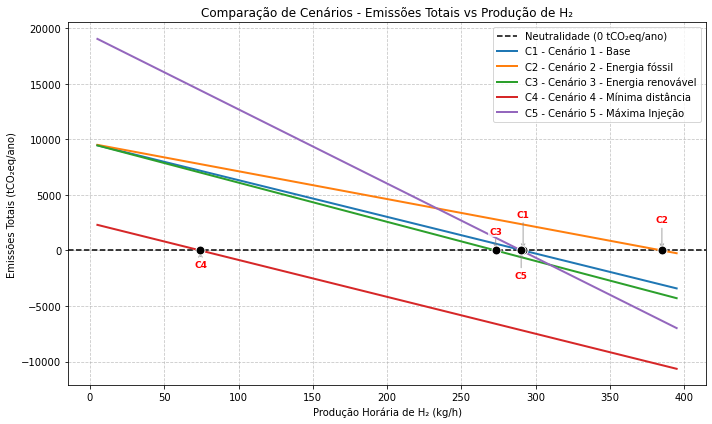

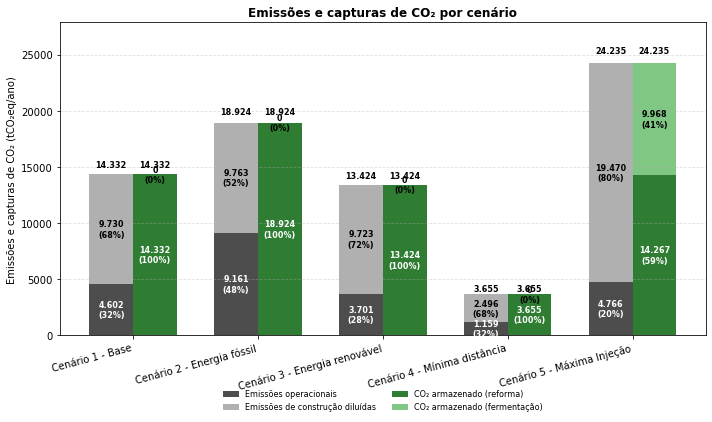

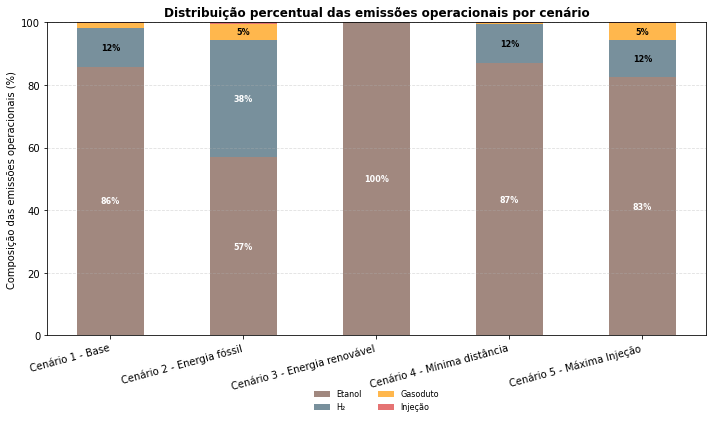


=== Funções lineares ajustadas (y = a·x + b) ===
                                       a             b
Cenário                                               
Cenário 1 - Base              -33.009642   9626.526424
Cenário 2 - Energia fóssil    -24.999155   9626.526424
Cenário 3 - Energia renovável -35.241653   9626.526424
Cenário 4 - Mínima distância  -33.202408   2469.270886
Cenário 5 - Máxima Injeção    -66.710023  19366.942447

=== Tabela detalhada no ponto neutro ===
                           Cenário 1 - Base  Cenário 2 - Energia fóssil  Cenário 3 - Energia renovável  Cenário 4 - Mínima distância  Cenário 5 - Máxima Injeção
Variável                                                                                                                                                        
producao_h2_h                       291.628                     385.074                        273.158                        74.370                     290.315
h2_anual                           2171.

In [ ]:
# ============================================================
# Execução principal
# ============================================================

def main():
    params = Params()

    # Definição dos cenários de simulação
    cenarios = [
        {"nome": "Cenário 1 - Base", "tamanho_gasoduto": 400, "profundidade_injecao": 1000,
         "fe_eletricidade": 0.0523, "emissao_fermentacao_co2": 0},
        {"nome": "Cenário 2 - Energia fóssil", "tamanho_gasoduto": 400, "profundidade_injecao": 1000,
         "fe_eletricidade": 0.24, "emissao_fermentacao_co2": 0},
        {"nome": "Cenário 3 - Energia renovável", "tamanho_gasoduto": 400, "profundidade_injecao": 1000,
         "fe_eletricidade": 0.0, "emissao_fermentacao_co2": 0},
        {"nome": "Cenário 4 - Mínima distância", "tamanho_gasoduto": 100, "profundidade_injecao": 800,
         "fe_eletricidade": 0.0523, "emissao_fermentacao_co2": 0},
        {"nome": "Cenário 5 - Máxima Injeção", "tamanho_gasoduto": 800, "profundidade_injecao": 3000,
         "fe_eletricidade": 0.0523, "emissao_fermentacao_co2": 0.949},
    ]

    # Dicionário para armazenar os resultados no ponto de neutralidade
    resultados = {}

    # Geração dos gráficos principais
    plotar_cenarios(cenarios, params, resultados)
    plotar_barras_cenarios(resultados)
    plotar_percentual_emissoes_operacionais(resultados)

    # Consolidação dos resultados detalhados no ponto neutro
    df = pd.DataFrame(resultados).round(3)
    df.index.name = "Variável"

    # Ajuste das funções lineares para cada cenário
    df_retas = calcular_funcoes_lineares(cenarios, params)

    print("\n=== Tabela detalhada no ponto neutro ===")
    print(df.to_string())

    # Exporta os resultados para arquivos CSV
    df.to_csv(
        r"nome_do_arquivo",
        sep=";", decimal=",", encoding="utf-8-sig"
    )
    df_retas.to_csv(
        r"nome_do_arquivo",
        sep=";", decimal=",", encoding="utf-8-sig"
    )


if __name__ == "__main__":
    main()